In [599]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
from curve_models import NLLS, NLLS_w, NLLS_rse, power_law, CurveModel, linearized_power_law

def calc_pct(pred_best, pred_worst, pred_curr):
    return (pred_worst - pred_curr)/(pred_worst - pred_best)

dataset_titles = {'gl': 'GoogleLocal-L', 'gl-tiny': 'GoogleLocal-S', 'ml-20m-tiny': 'MovieLens-S',
                 'ml-20m-uniform': 'MovieLens-L'}
gl_expmt = '5_False_0.1_0.4_uniform_19000_30_1_190000_3800_0_0.5_0.5_0_0.8'
ml_expmt = '5_False_0.1_0.4_uniform_100000_30_1_1000000_20000_0_0.5_0.5_0_0.8'
mltiny_expmt = '3_False_0.1_0.4_uniform_20000_4000_0_30_1_200000_0.5_0.5_0_0.8'
gltiny_expmt = '5_False_0.1_0.4_uniform_9400_30_1_94000_1880_0_0.5_0.5_0_0.8'
expmts = [('gl', gl_expmt), ('gl-tiny', gltiny_expmt), ('ml-20m-uniform', ml_expmt), ('ml-20m-tiny', mltiny_expmt)]
for dataset_name, expmt in expmts:
    results_path = '../results/forecasting/' + dataset_name + '/Random/' + expmt +'/'
    all_ss = np.loadtxt(results_path + 'sample_sizes')
    all_mses = np.loadtxt(results_path + 'mses')
    all_test_mses = np.loadtxt(results_path + 'test_mses')

    data = pd.read_csv(results_path + 'results_df')
    n_init = data['n_init'].iloc[0]
    n_observable = data['n_observable'].iloc[0]
    worst_mse = data[data['run'] == 2]['worst_mse'].iloc[0]
    best_mse = data[data['run'] == 2]['best_mse'].iloc[0]
    results = []
    n_runs = 5
    if dataset_name == 'ml-20m-tiny':
        n_runs = 3
    for j in range(n_runs):
        ss = all_ss[j]
        mses = all_mses[j]
        test_mses = all_test_mses[j]
        n_pts = len(np.where(ss) > n_init)
        for i, (size, mse) in enumerate(zip(ss, mses)):
            if size < n_init:
                continue
            
            pct_available = (size-n_init)/(n_observable-n_init)
            true_pct = (worst_mse - mse)/(worst_mse - best_mse)
            results.append({'pred_best': best_mse, 'pred_worst': worst_mse, 'pred_curr': mse,
                            'pred_pct': true_pct, 'true_curr': mse, 'cm': 'True', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})

            # TODO: implement linear and init 
            results.append({'pred_best': best_mse, 'pred_worst': worst_mse, 'pred_curr': mse,
                            'pred_pct': (size-n_init)/(n_observable-n_init), 'true_curr': mse, 
                            'cm': 'Linear', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})

            # initial
            nlls = NLLS(power_law)
            stop_pt = min(np.where(ss > n_init)[0])
            nlls.fit(ss[:5], mses[:5])
            pred_worst = nlls.f(n_init, **nlls.p)
            pred_best = nlls.f(n_observable, **nlls.p)
            pred_curr = nlls.f(size, **nlls.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_initial', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})

            # this baseline fits the power law curve to all points
            nlls = NLLS(power_law)
            nlls.fit(ss[:i+1], mses[:i+1])
            pred_worst = nlls.f(n_init, **nlls.p)
            pred_best = nlls.f(n_observable, **nlls.p)
            pred_curr = nlls.f(size, **nlls.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})

            # this method fits the weighted power law curve to all pts
            nlls_w = NLLS_w(power_law)
            nlls_w.fit(ss[:i+1], mses[:i+1])
            pred_worst = nlls_w.f(n_init, **nlls_w.p)
            pred_best = nlls_w.f(n_observable, **nlls_w.p)
            pred_curr = nlls_w.f(size, **nlls_w.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_w', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})
            # this method fits a beginning power law curve and an end one
            start_cm = NLLS_rse(linearized_power_law)
            start = 0
            end = np.min([9, i+1])
            end = int(i/2)
            start_cm.fit(ss[start:end], mses[start:end])

            end_cm = NLLS_rse(linearized_power_law)
            start = int(i/2)
            end_cm.fit(ss[start:i+1], mses[start:i+1])

            pred_worst = start_cm.f(n_init, **start_cm.p)
            pred_best = end_cm.f(n_observable, **end_cm.p)
            pred_curr = end_cm.f(size, **end_cm.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_mix', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})

    pd.DataFrame(results).to_csv('../results/forecasting/' + dataset_name + '/pred_performance')

[[1.11046575e-09 4.33894274e-04]
 [4.33894274e-04 1.70216676e+02]]
[[5.31177789e-10 2.21659140e-04]
 [2.21659140e-04 9.29720726e+01]]
[[1.11046575e-09 4.33894274e-04]
 [4.33894274e-04 1.70216676e+02]]
[[4.47553863e-10 1.89720948e-04]
 [1.89720948e-04 8.08566992e+01]]
[[1.11046575e-09 4.33894274e-04]
 [4.33894274e-04 1.70216676e+02]]
[[3.85459908e-10 1.65725150e-04]
 [1.65725150e-04 7.16509773e+01]]
[[1.11046575e-09 4.33894274e-04]
 [4.33894274e-04 1.70216676e+02]]
[[3.37729369e-10 1.46879727e-04]
 [1.46879727e-04 6.42480561e+01]]
[[1.11046575e-09 4.33894274e-04]
 [4.33894274e-04 1.70216676e+02]]
[[3.00016324e-10 1.31686128e-04]
 [1.31686128e-04 5.81446989e+01]]
[[1.11046575e-09 4.33894274e-04]
 [4.33894274e-04 1.70216676e+02]]
[[2.69543314e-10 1.19288921e-04]
 [1.19288921e-04 5.31138648e+01]]
[[1.11046575e-09 4.33894274e-04]
 [4.33894274e-04 1.70216676e+02]]
[[2.44457236e-10 1.08990265e-04]
 [1.08990265e-04 4.88948277e+01]]
[[1.11046575e-09 4.33894274e-04]
 [4.33894274e-04 1.70216676e+

[[7.90969735e-11 3.49577254e-05]
 [3.49577254e-05 1.55598020e+01]]
[[1.09608377e-09 4.26953587e-04]
 [4.26953587e-04 1.66976637e+02]]
[[7.66096647e-11 3.37950919e-05]
 [3.37950919e-05 1.50143194e+01]]
[[1.09608377e-09 4.26953587e-04]
 [4.26953587e-04 1.66976637e+02]]
[[7.42737943e-11 3.26994427e-05]
 [3.26994427e-05 1.44987574e+01]]
[[1.09608377e-09 4.26953587e-04]
 [4.26953587e-04 1.66976637e+02]]
[[7.20761749e-11 3.16644703e-05]
 [3.16644703e-05 1.40101111e+01]]
[[1.09608377e-09 4.26953587e-04]
 [4.26953587e-04 1.66976637e+02]]
[[7.00041291e-11 3.06923897e-05]
 [3.06923897e-05 1.35528121e+01]]
[[1.09608377e-09 4.26953587e-04]
 [4.26953587e-04 1.66976637e+02]]
[[6.80483745e-11 2.97694157e-05]
 [2.97694157e-05 1.31164646e+01]]
[[1.09608377e-09 4.26953587e-04]
 [4.26953587e-04 1.66976637e+02]]
[[6.61983376e-11 2.89005674e-05]
 [2.89005674e-05 1.27075425e+01]]
[[1.09608377e-09 4.26953587e-04]
 [4.26953587e-04 1.66976637e+02]]
[[6.44462728e-11 2.80775352e-05]
 [2.80775352e-05 1.23201985e+

[[1.07812478e-09 4.44554887e-04]
 [4.44554887e-04 1.84046055e+02]]
[[3.28494778e-10 1.48636164e-04]
 [1.48636164e-04 6.76449378e+01]]
[[1.07812478e-09 4.44554887e-04]
 [4.44554887e-04 1.84046055e+02]]
[[2.91872947e-10 1.33196814e-04]
 [1.33196814e-04 6.11475443e+01]]
[[1.07812478e-09 4.44554887e-04]
 [4.44554887e-04 1.84046055e+02]]
[[2.62277975e-10 1.20718653e-04]
 [1.20718653e-04 5.59028981e+01]]
[[1.07812478e-09 4.44554887e-04]
 [4.44554887e-04 1.84046055e+02]]
[[2.37911463e-10 1.10198158e-04]
 [1.10198158e-04 5.13611883e+01]]
[[1.07812478e-09 4.44554887e-04]
 [4.44554887e-04 1.84046055e+02]]
[[2.17532019e-10 1.01146366e-04]
 [1.01146366e-04 4.73289137e+01]]
[[1.07812478e-09 4.44554887e-04]
 [4.44554887e-04 1.84046055e+02]]
[[2.00255407e-10 9.33839349e-05]
 [9.33839349e-05 4.38279539e+01]]
[[1.07812478e-09 4.44554887e-04]
 [4.44554887e-04 1.84046055e+02]]
[[1.85436289e-10 8.67758986e-05]
 [8.67758986e-05 4.08726299e+01]]
[[1.07812478e-09 4.44554887e-04]
 [4.44554887e-04 1.84046055e+

[[1.11590071e-09 4.31888949e-04]
 [4.31888949e-04 1.67825171e+02]]
[[7.36790567e-11 3.30100632e-05]
 [3.30100632e-05 1.48957203e+01]]
[[1.11590071e-09 4.31888949e-04]
 [4.31888949e-04 1.67825171e+02]]
[[7.15672671e-11 3.19978249e-05]
 [3.19978249e-05 1.44092819e+01]]
[[1.11590071e-09 4.31888949e-04]
 [4.31888949e-04 1.67825171e+02]]
[[6.95730408e-11 3.10432635e-05]
 [3.10432635e-05 1.39512213e+01]]
[[1.11590071e-09 4.31888949e-04]
 [4.31888949e-04 1.67825171e+02]]
[[6.76865688e-11 3.01443035e-05]
 [3.01443035e-05 1.35216226e+01]]
[[1.11590071e-09 4.31888949e-04]
 [4.31888949e-04 1.67825171e+02]]
[[6.59007190e-11 2.92863939e-05]
 [2.92863939e-05 1.31088390e+01]]
[[1.11590071e-09 4.31888949e-04]
 [4.31888949e-04 1.67825171e+02]]
[[6.42060840e-11 2.84791154e-05]
 [2.84791154e-05 1.27233370e+01]]
[[1.11590071e-09 4.31888949e-04]
 [4.31888949e-04 1.67825171e+02]]
[[6.25962330e-11 2.77157888e-05]
 [2.77157888e-05 1.23603832e+01]]
[[1.11590071e-09 4.31888949e-04]
 [4.31888949e-04 1.67825171e+

[[1.56110143e-09 2.85015087e-04]
 [2.85015087e-04 5.23731759e+01]]
[[4.50684148e-09 7.24237365e-04]
 [7.24237365e-04 1.16928143e+02]]
[[1.36741731e-09 2.53229100e-04]
 [2.53229100e-04 4.72085169e+01]]
[[4.50684148e-09 7.24237365e-04]
 [7.24237365e-04 1.16928143e+02]]
[[1.21442780e-09 2.27607338e-04]
 [2.27607338e-04 4.29509490e+01]]
[[4.50684148e-09 7.24237365e-04]
 [7.24237365e-04 1.16928143e+02]]
[[1.09084639e-09 2.06954982e-04]
 [2.06954982e-04 3.95393005e+01]]
[[4.50684148e-09 7.24237365e-04]
 [7.24237365e-04 1.16928143e+02]]
[[9.89140938e-10 1.89364651e-04]
 [1.89364651e-04 3.65123780e+01]]
[[4.50684148e-09 7.24237365e-04]
 [7.24237365e-04 1.16928143e+02]]
[[9.04099789e-10 1.74713718e-04]
 [1.74713718e-04 3.40088302e+01]]
[[4.50684148e-09 7.24237365e-04]
 [7.24237365e-04 1.16928143e+02]]
[[8.32042324e-10 1.62020584e-04]
 [1.62020584e-04 3.17830993e+01]]
[[4.50684148e-09 7.24237365e-04]
 [7.24237365e-04 1.16928143e+02]]
[[7.70276410e-10 1.50810818e-04]
 [1.50810818e-04 2.97482146e+

[[4.54132291e-09 7.48540625e-04]
 [7.48540625e-04 1.23960435e+02]]
[[2.75069587e-10 5.51462738e-05]
 [5.51462738e-05 1.11472337e+01]]
[[4.54132291e-09 7.48540625e-04]
 [7.48540625e-04 1.23960435e+02]]
[[2.67819340e-10 5.36123443e-05]
 [5.36123443e-05 1.08209729e+01]]
[[4.54132291e-09 7.48540625e-04]
 [7.48540625e-04 1.23960435e+02]]
[[2.60946058e-10 5.21460051e-05]
 [5.21460051e-05 1.05068063e+01]]
[[4.54132291e-09 7.48540625e-04]
 [7.48540625e-04 1.23960435e+02]]
[[2.54418719e-10 5.07516022e-05]
 [5.07516022e-05 1.02077541e+01]]
[[4.54132291e-09 7.48540625e-04]
 [7.48540625e-04 1.23960435e+02]]
[[2.48208212e-10 4.94355455e-05]
 [4.94355455e-05 9.92756034e+00]]
[[4.54132291e-09 7.48540625e-04]
 [7.48540625e-04 1.23960435e+02]]
[[2.42295249e-10 4.81824374e-05]
 [4.81824374e-05 9.66079003e+00]]
[[4.54132291e-09 7.48540625e-04]
 [7.48540625e-04 1.23960435e+02]]
[[2.36662289e-10 4.69787756e-05]
 [4.69787756e-05 9.40272754e+00]]
[[4.54132291e-09 7.48540625e-04]
 [7.48540625e-04 1.23960435e+

[[4.64114304e-09 7.41905312e-04]
 [7.41905312e-04 1.19152507e+02]]
[[6.91412086e-10 1.36774239e-04]
 [1.36774239e-04 2.72644154e+01]]
[[4.64114304e-09 7.41905312e-04]
 [7.41905312e-04 1.19152507e+02]]
[[6.48984494e-10 1.28843688e-04]
 [1.28843688e-04 2.57778342e+01]]
[[4.64114304e-09 7.41905312e-04]
 [7.41905312e-04 1.19152507e+02]]
[[6.11355645e-10 1.21665854e-04]
 [1.21665854e-04 2.44019360e+01]]
[[4.64114304e-09 7.41905312e-04]
 [7.41905312e-04 1.19152507e+02]]
[[5.77763785e-10 1.15194192e-04]
 [1.15194192e-04 2.31480905e+01]]
[[4.64114304e-09 7.41905312e-04]
 [7.41905312e-04 1.19152507e+02]]
[[5.47595698e-10 1.09392421e-04]
 [1.09392421e-04 2.20262334e+01]]
[[4.64114304e-09 7.41905312e-04]
 [7.41905312e-04 1.19152507e+02]]
[[5.20362574e-10 1.04161510e-04]
 [1.04161510e-04 2.10161873e+01]]
[[4.64114304e-09 7.41905312e-04]
 [7.41905312e-04 1.19152507e+02]]
[[4.95670757e-10 9.93722338e-05]
 [9.93722338e-05 2.00816711e+01]]
[[4.64114304e-09 7.41905312e-04]
 [7.41905312e-04 1.19152507e+

[[3.25017076e-11 1.20008445e-04]
 [1.20008445e-04 4.44406463e+02]]
[[2.14320733e-12 8.25532928e-06]
 [8.25532928e-06 3.19763192e+01]]
[[3.25017076e-11 1.20008445e-04]
 [1.20008445e-04 4.44406463e+02]]
[[2.08416738e-12 8.00859156e-06]
 [8.00859156e-06 3.09462465e+01]]
[[3.25017076e-11 1.20008445e-04]
 [1.20008445e-04 4.44406463e+02]]
[[2.02833185e-12 7.77425364e-06]
 [7.77425364e-06 2.99647521e+01]]
[[3.25017076e-11 1.20008445e-04]
 [1.20008445e-04 4.44406463e+02]]
[[1.97545071e-12 7.55123644e-06]
 [7.55123644e-06 2.90272454e+01]]
[[3.25017076e-11 1.20008445e-04]
 [1.20008445e-04 4.44406463e+02]]
[[1.92527077e-12 7.34099984e-06]
 [7.34099984e-06 2.81486694e+01]]
[[3.25017076e-11 1.20008445e-04]
 [1.20008445e-04 4.44406463e+02]]
[[1.87759848e-12 7.14179568e-06]
 [7.14179568e-06 2.73183518e+01]]
[[3.25017076e-11 1.20008445e-04]
 [1.20008445e-04 4.44406463e+02]]
[[1.83225518e-12 6.95257240e-06]
 [6.95257240e-06 2.65307982e+01]]
[[3.25017076e-11 1.20008445e-04]
 [1.20008445e-04 4.44406463e+

[[1.45106229e-12 5.46231855e-06]
 [5.46231855e-06 2.06795762e+01]]
[[3.24300948e-11 1.23227288e-04]
 [1.23227288e-04 4.69602716e+02]]
[[1.42413529e-12 5.34904367e-06]
 [5.34904367e-06 2.02057708e+01]]
[[3.23882278e-11 1.21446839e-04]
 [1.21446839e-04 4.56719146e+02]]
[[1.55935633e-11 6.14402509e-05]
 [6.14402509e-05 2.42998596e+02]]
[[3.23882278e-11 1.21446839e-04]
 [1.21446839e-04 4.56719146e+02]]
[[1.31615411e-11 5.24734038e-05]
 [5.24734038e-05 2.10040781e+02]]
[[3.23882278e-11 1.21446839e-04]
 [1.21446839e-04 4.56719146e+02]]
[[1.13527794e-11 4.55954619e-05]
 [4.55954619e-05 1.83886123e+02]]
[[3.23882278e-11 1.21446839e-04]
 [1.21446839e-04 4.56719146e+02]]
[[9.96074939e-12 4.02201241e-05]
 [4.02201241e-05 1.63105543e+02]]
[[3.23882278e-11 1.21446839e-04]
 [1.21446839e-04 4.56719146e+02]]
[[8.85969557e-12 3.59196122e-05]
 [3.59196122e-05 1.46277061e+02]]
[[3.23882278e-11 1.21446839e-04]
 [1.21446839e-04 4.56719146e+02]]
[[7.96913259e-12 3.24201444e-05]
 [3.24201444e-05 1.32495681e+

[[3.23448742e-11 1.21778186e-04]
 [1.21778186e-04 4.59830495e+02]]
[[3.10589797e-12 1.24840971e-05]
 [1.24840971e-05 5.04516775e+01]]
[[3.23448742e-11 1.21778186e-04]
 [1.21778186e-04 4.59830495e+02]]
[[2.98300306e-12 1.19621856e-05]
 [1.19621856e-05 4.82310611e+01]]
[[3.23448742e-11 1.21778186e-04]
 [1.21778186e-04 4.59830495e+02]]
[[2.86946859e-12 1.14753891e-05]
 [1.14753891e-05 4.61426670e+01]]
[[3.23448742e-11 1.21778186e-04]
 [1.21778186e-04 4.59830495e+02]]
[[2.76423848e-12 1.10252877e-05]
 [1.10252877e-05 4.42163447e+01]]
[[3.23448742e-11 1.21778186e-04]
 [1.21778186e-04 4.59830495e+02]]
[[2.66644634e-12 1.06075923e-05]
 [1.06075923e-05 4.24314375e+01]]
[[3.23448742e-11 1.21778186e-04]
 [1.21778186e-04 4.59830495e+02]]
[[2.57533352e-12 1.02196873e-05]
 [1.02196873e-05 4.07789982e+01]]
[[3.23448742e-11 1.21778186e-04]
 [1.21778186e-04 4.59830495e+02]]
[[2.49026019e-12 9.85700211e-06]
 [9.85700211e-06 3.92325942e+01]]
[[3.23448742e-11 1.21778186e-04]
 [1.21778186e-04 4.59830495e+

[[3.24384131e-11 1.22346931e-04]
 [1.22346931e-04 4.62797538e+02]]
[[1.70813015e-12 6.48318125e-06]
 [6.48318125e-06 2.47463825e+01]]
[[3.24384131e-11 1.22346931e-04]
 [1.22346931e-04 4.62797538e+02]]
[[1.67064763e-12 6.32464406e-06]
 [6.32464406e-06 2.40793928e+01]]
[[3.24384131e-11 1.22346931e-04]
 [1.22346931e-04 4.62797538e+02]]
[[1.63477195e-12 6.17477705e-06]
 [6.17477705e-06 2.34555388e+01]]
[[3.24384131e-11 1.22346931e-04]
 [1.22346931e-04 4.62797538e+02]]
[[1.60044323e-12 6.03068426e-06]
 [6.03068426e-06 2.28535935e+01]]
[[3.24384131e-11 1.22346931e-04]
 [1.22346931e-04 4.62797538e+02]]
[[1.56755828e-12 5.89215316e-06]
 [5.89215316e-06 2.22734392e+01]]
[[3.24384131e-11 1.22346931e-04]
 [1.22346931e-04 4.62797538e+02]]
[[1.53600097e-12 5.76070577e-06]
 [5.76070577e-06 2.17282184e+01]]
[[3.24384131e-11 1.22346931e-04]
 [1.22346931e-04 4.62797538e+02]]
[[1.50571520e-12 5.63437004e-06]
 [5.63437004e-06 2.12037776e+01]]
[[3.24384131e-11 1.22346931e-04]
 [1.22346931e-04 4.62797538e+

[[6.63473298e-10 3.46267256e-04]
 [3.46267256e-04 1.81435650e+02]]
[[9.97130602e-11 6.42810429e-05]
 [6.42810429e-05 4.17172376e+01]]
[[6.63473298e-10 3.46267256e-04]
 [3.46267256e-04 1.81435650e+02]]
[[9.36306311e-11 6.07128974e-05]
 [6.07128974e-05 3.96347908e+01]]
[[6.63473298e-10 3.46267256e-04]
 [3.46267256e-04 1.81435650e+02]]
[[8.82359143e-11 5.74371455e-05]
 [5.74371455e-05 3.76443856e+01]]
[[6.63473298e-10 3.46267256e-04]
 [3.46267256e-04 1.81435650e+02]]
[[8.34178077e-11 5.45190042e-05]
 [5.45190042e-05 3.58775017e+01]]
[[6.63473298e-10 3.46267256e-04]
 [3.46267256e-04 1.81435650e+02]]
[[7.90913211e-11 5.18659607e-05]
 [5.18659607e-05 3.42486997e+01]]
[[6.63473298e-10 3.46267256e-04]
 [3.46267256e-04 1.81435650e+02]]
[[7.51872365e-11 4.94110872e-05]
 [4.94110872e-05 3.26989031e+01]]
[[6.63473298e-10 3.46267256e-04]
 [3.46267256e-04 1.81435650e+02]]
[[7.16434607e-11 4.72415414e-05]
 [4.72415414e-05 3.13703762e+01]]
[[6.63473298e-10 3.46267256e-04]
 [3.46267256e-04 1.81435650e+

[[3.81384027e-11 2.62287344e-05]
 [2.62287344e-05 1.81736185e+01]]
[[6.66848699e-10 3.54620766e-04]
 [3.54620766e-04 1.89333336e+02]]
[[3.72177472e-11 2.56105881e-05]
 [2.56105881e-05 1.77558956e+01]]
[[6.66848699e-10 3.54620766e-04]
 [3.54620766e-04 1.89333336e+02]]
[[3.63416803e-11 2.50142251e-05]
 [2.50142251e-05 1.73470824e+01]]
[[6.66848699e-10 3.54620766e-04]
 [3.54620766e-04 1.89333336e+02]]
[[3.55068253e-11 2.44415035e-05]
 [2.44415035e-05 1.69513655e+01]]
[[6.66848699e-10 3.54620766e-04]
 [3.54620766e-04 1.89333336e+02]]
[[3.47099631e-11 2.38957764e-05]
 [2.38957764e-05 1.65749405e+01]]
[[6.66848699e-10 3.54620766e-04]
 [3.54620766e-04 1.89333336e+02]]
[[3.39485211e-11 2.33755086e-05]
 [2.33755086e-05 1.62169086e+01]]
[[6.66848699e-10 3.54620766e-04]
 [3.54620766e-04 1.89333336e+02]]
[[3.32201618e-11 2.28798132e-05]
 [2.28798132e-05 1.58771593e+01]]
[[6.66848699e-10 3.54620766e-04]
 [3.54620766e-04 1.89333336e+02]]
[[3.25234328e-11 2.23994359e-05]
 [2.23994359e-05 1.55435332e+

In [600]:
all_results = []
for i, (dataset_name, _) in enumerate(expmts):
    results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
    results_df = results_df.round({'pred_pct': 2, 'true_pct': 2})
    results_df['dataset'] = dataset_name
    all_results.append(results_df)
all_results = pd.concat(all_results)

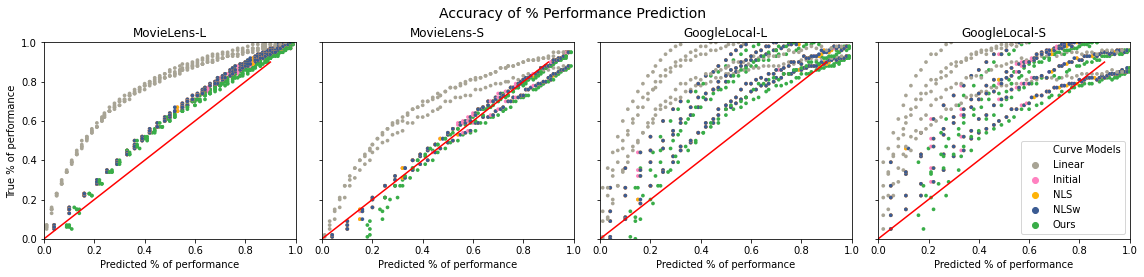

In [601]:
expmts = [('ml-20m-uniform', ml_expmt), ('ml-20m-tiny', mltiny_expmt), ('gl', gl_expmt), ('gl-tiny', gltiny_expmt)]
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green"]):
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

    for i, (dataset_name, _) in enumerate(expmts):
        #ax = axs[int(i/2), i%2]
        ax = axs[i]
        hue_order = ['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix']
        results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
        results_df = results_df.round({'pred_pct': 2, 'true_pct': 2})
        results_df['dataset'] = dataset_name
        cm_results = results_df[results_df['cm'] != 'True']
        sns.scatterplot(x='pred_pct', y='true_pct', data=cm_results, hue='cm', hue_order=hue_order, s=14,
                         linewidth=0, ax=ax)
        ax.plot([i for i in np.arange(0, 1, .1)], [i for i in np.arange(0, 1, .1)], c='r', label='True')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_ylabel("True % of performance")
        ax.set_xlabel("Predicted % of performance")
        if i != 3:
            ax.get_legend().remove()
        else:
            L=ax.get_legend()
            new_names = ['Curve Models', 'Linear', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)
        ax.set_title(dataset_titles[dataset_name])
plt.suptitle("Accuracy of % Performance Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figs/performance_pred.png')

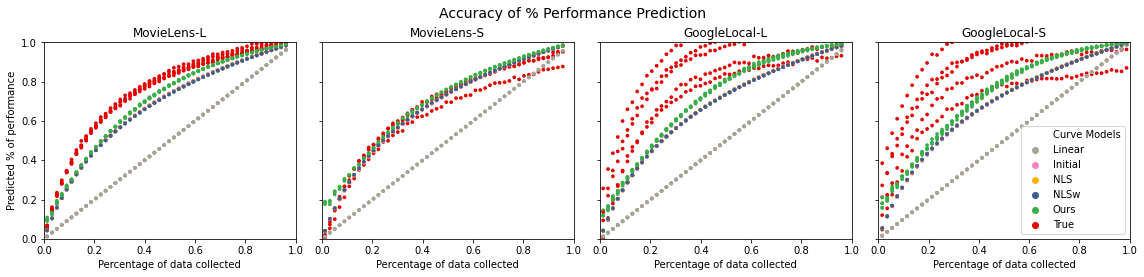

In [625]:
expmts = [('ml-20m-uniform', ml_expmt), ('ml-20m-tiny', mltiny_expmt), ('gl', gl_expmt), ('gl-tiny', gltiny_expmt)]
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green", "red"]):
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

    for i, (dataset_name, _) in enumerate(expmts):
        #ax = axs[int(i/2), i%2]
        ax  = axs[i]
        hue_order = ['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
        results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
        results_df = results_df.round({'pred_pct': 4, 'true_pct': 4})
        #cm_results = results_df[results_df['cm'] != 'True']
        sns.scatterplot(x='pct_available', y='pred_pct', data=results_df, hue='cm', hue_order=hue_order, s=14,
                          linewidth=0, ax=ax)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Predicted % of performance")
        ax.set_xlabel("Percentage of data collected")
        if i != 3:
            ax.get_legend().remove()
        else:
            L=ax.get_legend()
            new_names = ['Curve Models', 'Linear', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)
        ax.set_title(dataset_titles[dataset_name])
plt.suptitle("Accuracy of % Performance Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figs/performance_pred_v_pct_available.png')

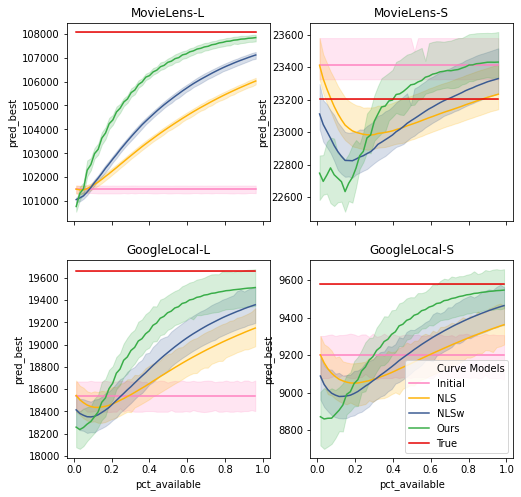

In [598]:
# plot best_mse prediction over pct_available
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8, 8))
hue_order = ['NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
with sns.xkcd_palette(["pink", "amber", "denim blue", "medium green", "red"]):
    for i, (dataset_name, _) in enumerate(expmts):

        ax = axs[int(i/2), i%2]
        forecasting_cms = all_results[all_results['cm'] !='Linear']
        dataset_results = forecasting_cms[forecasting_cms['dataset'] == dataset_name]
        sns.lineplot(x='pct_available', y='pred_best', hue='cm', data=dataset_results, ax=ax, hue_order=hue_order)
        ax.set_title(dataset_titles[dataset_name])
        if i != 3:
            ax.get_legend().remove()
        else:
            L=ax.get_legend()
            new_names = ['Curve Models', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)

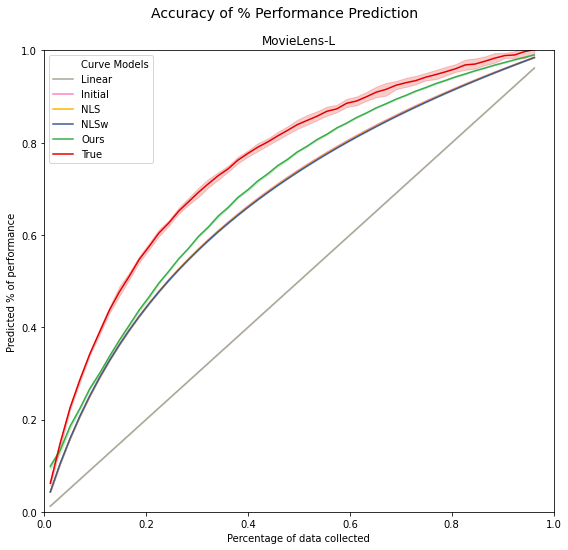

In [626]:
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green", "red"]):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 8))

    for i, (dataset_name, _) in enumerate(expmts):
        if dataset_name != 'ml-20m-uniform':
            continue
        hue_order = ['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
        results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
        results_df = results_df.round({'pred_pct': 4, 'true_pct': 4})
        #cm_results = results_df[results_df['cm'] != 'True']
        sns.lineplot(x='pct_available', y='pred_pct', data=results_df, hue='cm', hue_order=hue_order, ax = ax)
                         #s=14, linewidth=0
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Predicted % of performance")
        ax.set_xlabel("Percentage of data collected")

        L=ax.get_legend()
        new_names = ['Curve Models', 'Linear', 'Initial', 'NLS', 'NLSw', 'Ours']
        for i,new in enumerate(new_names):
            L.get_texts()[i].set_text(new)
        ax.set_title(dataset_titles[dataset_name])
plt.suptitle("Accuracy of % Performance Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figs/performance_pred_v_pct_available.png')

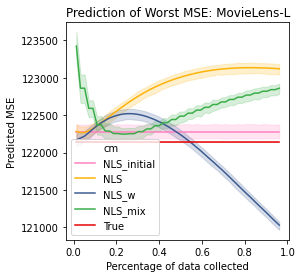

In [581]:
# plot best_mse prediction over pct_available
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4, 4))
hue_order = ['NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
dataset_name = 'ml-20m-uniform'
yname = 'pred_worst'
with sns.xkcd_palette(["pink", "amber", "denim blue", "medium green", "red"]):
        forecasting_cms = all_results[all_results['cm'] !='Linear']
        dataset_results = forecasting_cms[forecasting_cms['dataset'] == dataset_name]
        
        sns.lineplot(x='pct_available', y=yname, hue='cm', data=dataset_results, ax=ax, hue_order=hue_order)
        plt.xlabel("Percentage of data collected")
        plt.ylabel("Predicted MSE")
        if 'best' in yname:
            plt.title("Prediction of Best MSE: " + dataset_titles[dataset_name])
            L=ax.get_legend()
            new_names = ['Curve Models', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)
        else:
            plt.title("Prediction of Worst MSE: " + dataset_titles[dataset_name])

        

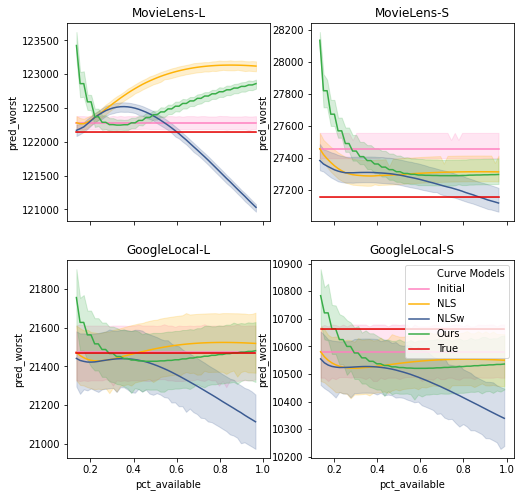

In [510]:
# plot best_mse prediction over pct_available
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8, 8))
hue_order = ['NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
with sns.xkcd_palette(["pink", "amber", "denim blue", "medium green", "red"]):
    for i, (dataset_name, _) in enumerate(expmts):
        ax = axs[int(i/2), i%2]
        forecasting_cms = all_results[all_results['cm'] !='Linear']
        dataset_results = forecasting_cms[forecasting_cms['dataset'] == dataset_name]
        sns.lineplot(x='pct_available', y='pred_worst', hue='cm', data=dataset_results, ax=ax, hue_order=hue_order)
        ax.set_title(dataset_titles[dataset_name])
        if i != 3:
            ax.get_legend().remove()
        else:
            L=ax.get_legend()
            new_names = ['Curve Models', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)

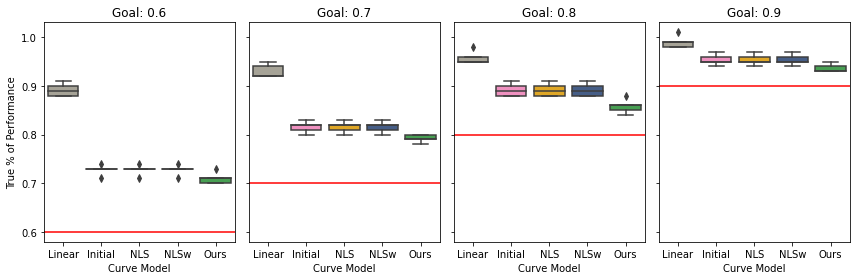

In [568]:
# Plot stopping criterions
goals = [.6, .7, .8, .9]
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 4))
dataset_name = 'ml-20m-uniform'
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green", "red"]):
    for i, g in enumerate(goals):
        ax = axs[i]
        test_df = all_results[all_results['pred_pct'] > g]
        test_df = test_df[test_df['cm'] != 'True']
        draw_df = test_df.sort_values('pred_pct').groupby(['cm', 'run', 'dataset']).first().reset_index()
        dataset_df = draw_df[draw_df['dataset'] == dataset_name]
        sns.boxplot(x='cm', y='true_pct', data=dataset_df, ax=ax,
                    order=['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix'])
        ax.set_xticklabels(['Linear', 'Initial', 'NLS', 'NLSw', 'Ours'])
        ax.axhline(y=g, c='r', label='Goal')
        ax.set_xlabel("Curve Model")
        ax.set_ylabel("True % of Performance")
        ax.set_title("Goal: " + str(g))
        if i > 0:
            ax.set_ylabel("")

plt.tight_layout()
# Filter pred_pct for being greater than goal percentage g 
# Choose the minimum entry, record true percentage
# For a given goal percentage g, at what point do different algorithms stop? 

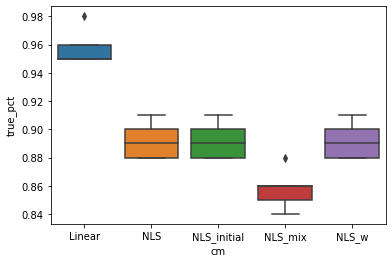

In [535]:
goals = [.8, .85, .9, .95]
g = .8



In [623]:
# initial
expmt  = '5_False_0.1_0.4_uniform_100000_30_1_1000000_20000_0_0.5_0.5_0_0.8'
dataset_name = 'ml-20m-uniform'
results_path = '../results/forecasting/' + dataset_name + '/Random/' + expmt +'/'
all_ss = np.loadtxt(results_path + 'sample_sizes')
all_mses = np.loadtxt(results_path + 'mses')
nlls_i = NLLS(power_law)
stop_pt = min(np.where(ss > n_init)[0])
nlls_i.fit(ss[:9], mses[:9])
pred_worst = nlls_i.f(n_init, **nlls_i.p)
pred_best = nlls_i.f(n_observable, **nlls_i.p)
pred_curr = nlls_i.f(size, **nlls_i.p)
pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
print(pred_pct)
results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_initial', 'true_pct': true_pct, 
                'pct_available': pct_available, 'run': j})

# this baseline fits the power law curve to all points
nlls = NLLS(power_law)
nlls.fit(ss[:20], mses[:20])
pred_worst = nlls.f(n_init, **nlls.p)
pred_best = nlls.f(n_observable, **nlls.p)
pred_curr = nlls.f(size, **nlls.p)
pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
print(pred_pct)
results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS', 'true_pct': true_pct, 
                'pct_available': pct_available, 'run': j})

# this method fits the weighted power law curve to all pts
nlls_w = NLLS_w(power_law)
nlls_w.fit(ss[:20], mses[:20])
pred_worst = nlls_w.f(n_init, **nlls_w.p)
pred_best = nlls_w.f(n_observable, **nlls_w.p)
pred_curr = nlls_w.f(size, **nlls_w.p)
pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
print(pred_pct)
results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_w', 'true_pct': true_pct, 
                'pct_available': pct_available, 'run': j})

[[2.69665744e-10 1.59100035e-04]
 [1.59100035e-04 9.43716422e+01]]
0.9830135490386372
[[9.43575150e-11 6.24037437e-05]
 [6.24037437e-05 4.15519282e+01]]
0.9831061874827484
0.9831626674414536


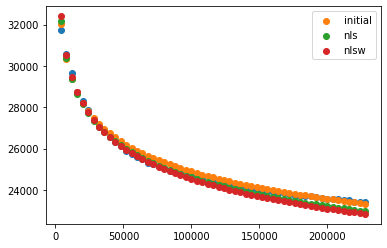

In [622]:
plt.scatter(ss, mses)
plt.scatter(ss, [nlls_i.f(s, **nlls_i.p) for s in ss], label='initial')
plt.scatter(ss, [nlls.f(s, **nlls.p) for s in ss], label='nls')
plt.scatter(ss, [nlls_w.f(s, **nlls_w.p) for s in ss], label='nlsw')
plt.legend()